In [95]:
import csv
from typing import Iterable, Dict
from os.path import join, abspath
from dataclasses import dataclass
from scipy import stats
import scipy
import numpy as np
import matplotlib.pyplot as plt


@dataclass(frozen=True)
class Measurement:
    area: float
    mean: float
    x: float
    y: float


def read_csv(filename: str) -> Iterable[Iterable[str]]:
    """
    Read a CSV file and return a list of rows.
    """


def _get_code_dir() -> str:
    return abspath("")


def _get_data_dir() -> str:
    return join(_get_code_dir(), "data", "output")


def _get_measurement_path(number: int) -> str:
    return join(_get_data_dir(), f"MHV_measurements_{number}.csv")


def _parse_row(row: Dict[str, str]) -> Measurement:
    return Measurement(
        area=float(row["Area"]),
        mean=float(row["Mean"]),
        x=float(row["X"]),
        y=float(row["Y"]),
    )


def read_measurement(number: int) -> Iterable[Measurement]:
    path = _get_measurement_path(number)
    with open(path, "r") as f:
        return [_parse_row(row) for row in csv.DictReader(f)]


def read_measurements_by_images() -> Iterable[Iterable[Measurement]]:
    return [read_measurement(number) for number in range(6)]


def read_measurements() -> Iterable[Measurement]:
    return [
        measurement for image in read_measurements_by_images() for measurement in image
    ]


def filter_nuclei(measurements: Iterable[Measurement]) -> Iterable[Measurement]:
    return [measurement for measurement in measurements if 10 < measurement.area < 1000]


Read 9969 measurements.
Filtered 8967 nuclei measurements.


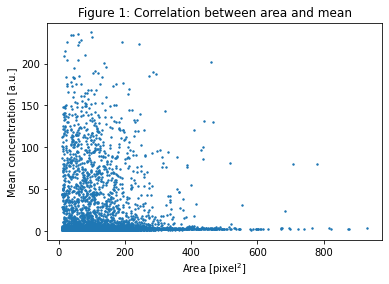

Correlation: 0.0696863169522345
p-value: 3.9483044550927544e-11


In [96]:
measurements = read_measurements()
print(f"Read {len(measurements)} measurements.")
measurements = filter_nuclei(measurements)
print(f"Filtered {len(measurements)} nuclei measurements.")
areas = np.array([measurement.area for measurement in measurements])
means = np.array([measurement.mean for measurement in measurements])

plt.title("Figure 1: Correlation between area and mean")
plt.scatter(areas, means, s=2)
plt.xlabel("Area [pixel$^2$]")
plt.ylabel("Mean concentration [a.u.]")
plt.show()


correlation, p_value = stats.spearmanr(means, areas)
print(f"Correlation: {correlation}")
print(f"p-value: {p_value}")


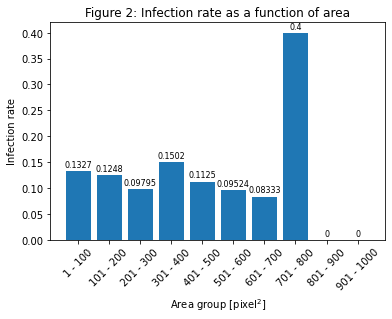

In [97]:
def is_infected(measurement: Measurement) -> bool:
    return measurement.mean > 12


group_size = 100
max_area = 1000
groups = [
    (begin, begin + group_size - 1) for begin in np.arange(1, max_area, group_size)
]
infection_rates = []
for begin, end in groups:
    group_measurements = [
        measurement for measurement in measurements if begin <= measurement.area <= end
    ]
    infected_measurements = [
        measurement for measurement in group_measurements if is_infected(measurement)
    ]
    infection_rate = (
        len(infected_measurements) / len(group_measurements)
        if len(infected_measurements) > 0
        else 0
    )
    infection_rates.append(infection_rate)
labels = [f"{begin} - {end}" for begin, end in groups]
fig, ax = plt.subplots()
ax.set_title("Figure 2: Infection rate as a function of area")
ax.bar(labels, infection_rates)
ax.set_xlabel("Area group [pixel$^2$]")
ax.set_ylabel("Infection rate")
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=45)
for i, infection_rate in enumerate(infection_rates):
    ax.annotate(
        f"{infection_rate:.4g}",
        xy=(labels[i], infection_rate),
        xytext=(0, 2),
        textcoords="offset points",
        ha="center",
        va="bottom",
        size=8,
    )
plt.show()


In [98]:
def divide_into_squares(
    measurements: Iterable[Measurement], width: int, height: int
) -> Iterable[Iterable[int]]:
    max_x = int(max(measurement.x for measurement in measurements) + width)
    max_y = int(max(measurement.y for measurement in measurements) + height)

    return [
        [
            measurement
            for measurement in measurements
            if left <= measurement.x <= left + width
            and top <= measurement.y <= top + height
        ]
        for left in range(0, max_x, width)
        for top in range(0, max_y, height)
    ]


def group_by_density(squares: Iterable[Iterable[Measurement]]) -> Iterable[float]:
    max_centroid_count = max(len(square) for square in squares)
    return [
        [
            measurement
            for square in squares
            for measurement in square
            if len(square) == density
        ]
        for density in range(max_centroid_count)
    ]


def filter_infected_density_groups(
    density_groups: Iterable[Iterable[Measurement]],
) -> Iterable[Iterable[Measurement]]:
    return [
        [measurement for measurement in measurements if is_infected(measurement)]
        for measurements in density_groups
    ]


In [100]:
width = 48
height = 52
images = read_measurements_by_images()
squares = [divide_into_squares(measurements, width, height) for measurements in images]
squares = sum(squares, [])
density_groups = group_by_density(squares)
infected_density_groups = filter_infected_density_groups(density_groups)
infection_rates = [
    len(infected_measurements) / len(density_measumerents)
    if len(density_measumerents) > 0
    else 0
    for infected_measurements, density_measumerents in zip(
        infected_density_groups, density_groups
    )
]


In [103]:
density_of_interest = 5
print(f"The infection rate for a density of {density_of_interest} is: {infection_rates[density_of_interest]:.2g}")

The infection rate for a density of 5 is: 0.12
